# Long Short Term Memory Model to Predict Weather in New Delhi

This notebook aims to forecast the mean temperature in New Delhi using 4 different features (mean temperature, humidity, wind speed and mean pressure).

A Biderectional Long Short Term Memory model is used for this purpose. The dataset is a time series and the model built in this case uses the previous 30 days of data to forecast the mean temperature of the next day.

In a bidirectional LSTM, we give the input from both right to left and from left to right.

## Importing of Packages

Here, we import the necessary packages such as numpy (for numerical and array calculations), pandas (data-handling) and torch (building of machine learning model).

In [69]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn   # neural network modules
import torch.optim as optim   # optimization algorithms
import torch.nn.functional as F   # functions without parameters like activation functions
from torch.utils.data import TensorDataset, DataLoader, Dataset   # dataset management, create batches
import torchvision.datasets as datasets   # standard datasets on pytorch
import torchvision.transforms as transforms   #transform datasets

import matplotlib.pyplot as plt

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

## Device

Set device to GPU if available, else, send to CPU. The data and model will be sent to the device.

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Exploratory Data Analysis

In [71]:
train_dataset = pd.read_csv("DailyDelhiClimateTrain.csv")

print(f"Full train dataset shape is {train_dataset.shape}")

Full train dataset shape is (1462, 5)


In [72]:
train_dataset.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


Examine the data distribution for each column to decide what should be considered outliers.

Examine the data points briefly using a box plot. This helps us to visualise the data and identify outliers at a glance.

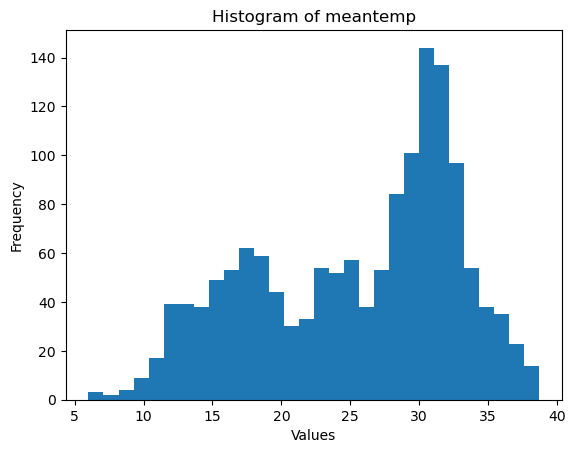

In [73]:
plt.hist(train_dataset['meantemp'], bins=30)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of meantemp')
plt.show()

The mean temperature data does not seem to have any outliers from the distribution.

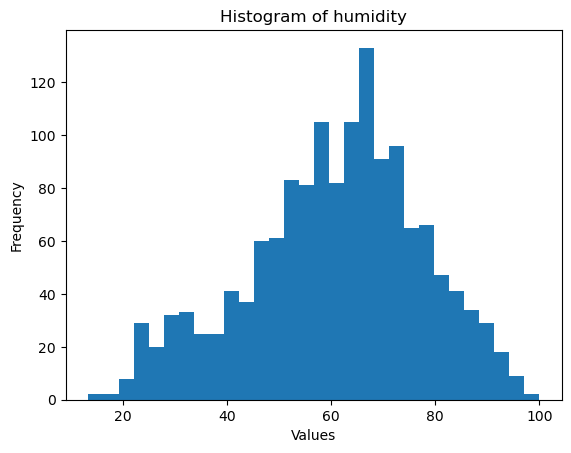

In [74]:
plt.hist(train_dataset['humidity'], bins=30)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of humidity')
plt.show()

The humidity data does not seem to have any outliers from the distribution.

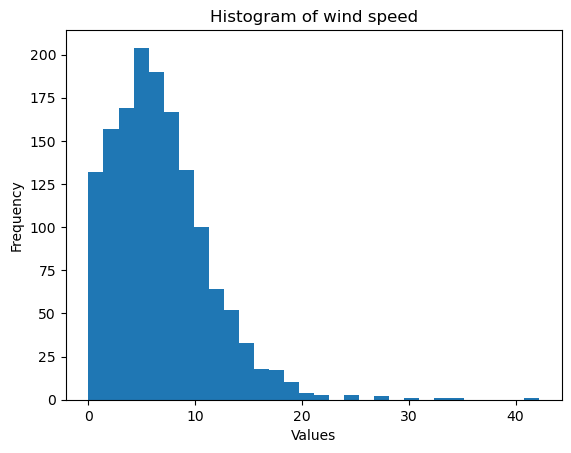

In [75]:
plt.hist(train_dataset['wind_speed'], bins=30)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of wind speed')
plt.show()

The wind speed data is skewed towards one side and hence, the nature of the distribution might mean that the data points with larger values might not actually be outliers.

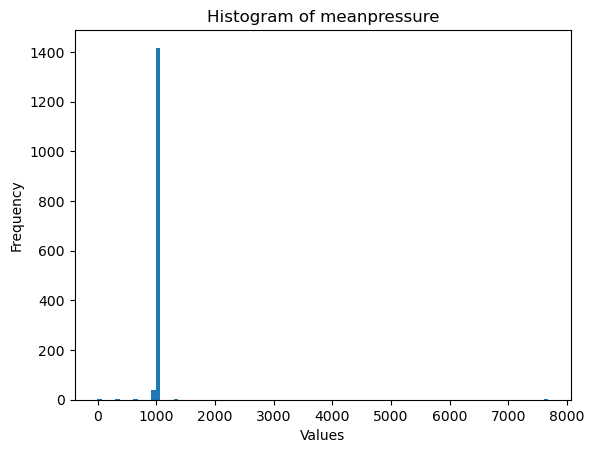

In [76]:
plt.hist(train_dataset['meanpressure'], bins=100)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of meanpressure')
plt.show()

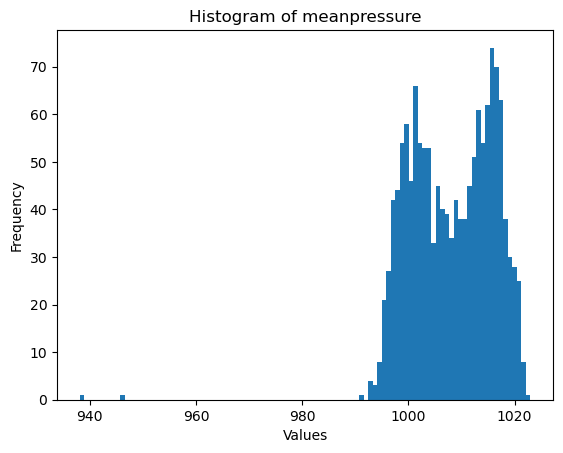

In [77]:
meanpressure_wo_outlier = train_dataset['meanpressure'][train_dataset['meanpressure'] <= 1300][train_dataset['meanpressure'] >= 700]

plt.hist(meanpressure_wo_outlier, bins=100)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of meanpressure')
plt.show()


The mean pressure data has a distribution that is centred around 1000 and has several outliers that are far from the range where most values lie.

<Axes: >

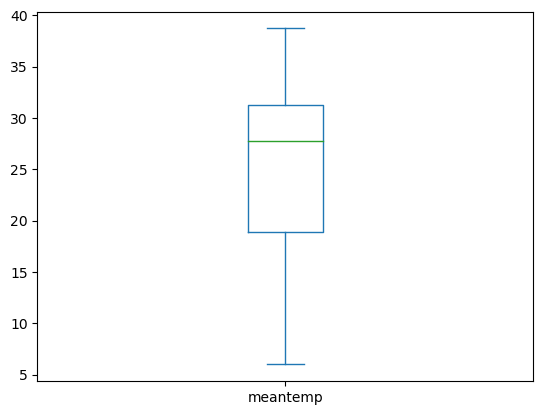

In [78]:
train_dataset['meantemp'].plot(kind='box')

Mean temperature data does not have any outliers.

<Axes: >

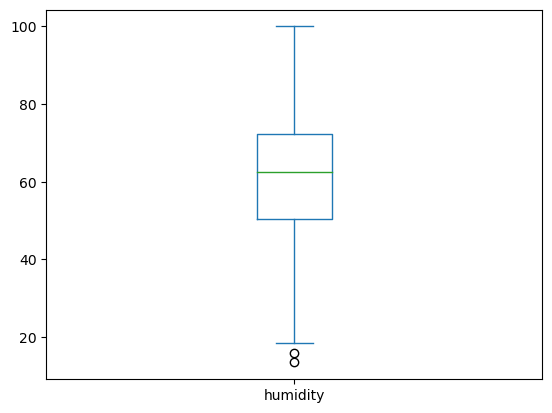

In [79]:
train_dataset['humidity'].plot(kind='box')

Not sure if humidity data has outliers but there are a few data points outside 1.5 times of IQR.

IQR is the 2nd and 3rd quartile of data.

<Axes: >

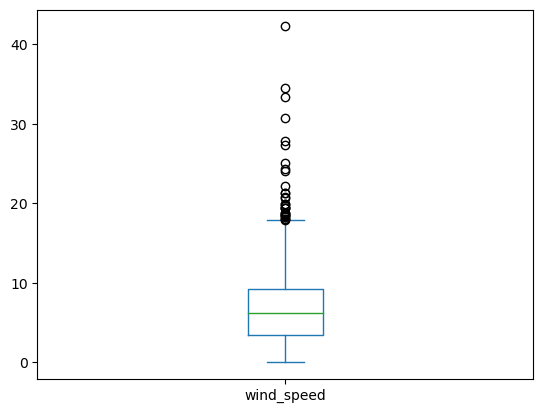

In [80]:
train_dataset['wind_speed'].plot(kind='box')

Wind speed data has outliers which need to be removed.

<Axes: >

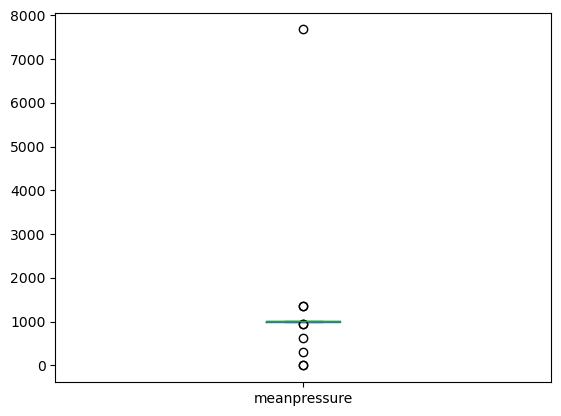

In [81]:
train_dataset['meanpressure'].plot(kind='box')

Mean pressure data has outliers which need to be removed.

We take a closer look at the data to find outliers and if it is necessary to remove them.

In [82]:
train_dataset.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


We remove outliers using z-score (number of standard deviations by which the value of a raw score is above or below the mean value) and we set the limit to 3. As seen from the table above, this only applies to wind speed and mean pressure.

In [83]:
from scipy import stats

z_meanpressure = np.abs(stats.zscore(train_dataset['meanpressure']))

z_data = [z_meanpressure]
z_list = []
for x in z_data:
    z_list.extend(np.where(x>3)[0].flatten().tolist())

print(len(z_list))
train_dataset = train_dataset.drop(index = z_list, axis=0)

final_dataset = pd.DataFrame(train_dataset)
print(final_dataset.shape)

4
(1458, 5)


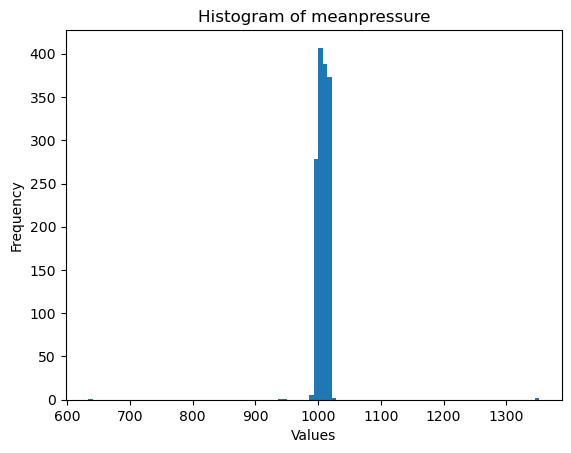

In [84]:
plt.hist(train_dataset['meanpressure'], bins=100)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of meanpressure')
plt.show()

There are still some outliers after removing using the z-scores. Thus, we will remove those manually.

In [85]:
train_dataset['meanpressure'] = train_dataset['meanpressure'][train_dataset['meanpressure'] <= 1300][train_dataset['meanpressure'] >= 950]

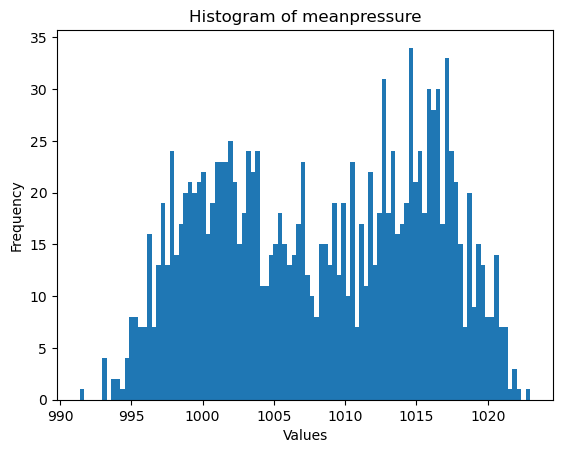

In [86]:
plt.hist(train_dataset['meanpressure'], bins=100)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of meanpressure')
plt.show()

<Axes: >

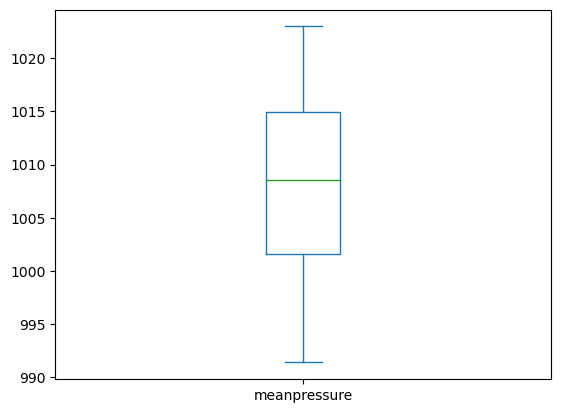

In [87]:
train_dataset['meanpressure'].plot(kind='box')

In [88]:
final_dataset['date'] = pd.to_datetime(final_dataset['date'])

final_dataset.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


Create the feature set which is a numpy array containing the data for 4 features and for all rows.

We then choose the mean temperature to be the predicted value.

## Making Sure that Features are Independent (IID)

We use the correlation matrix to find out the correlation coefficients between each pair of features.

In [89]:
correlation_matrix = train_dataset.corr()
print(correlation_matrix)

              meantemp  humidity  wind_speed  meanpressure
meantemp      1.000000 -0.573635    0.306203     -0.878969
humidity     -0.573635  1.000000   -0.374614      0.332819
wind_speed    0.306203 -0.374614    1.000000     -0.294541
meanpressure -0.878969  0.332819   -0.294541      1.000000


/var/folders/30/bxcxv8sj19z2tjt6271b_g9m0000gn/T/ipykernel_70068/1550695401.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_dataset.corr()


It can be seen that the input features (humidity, wind speed and mean pressure) do not have high correlations with one another and thus they are rather independent.

In [90]:
feature_set = final_dataset.iloc[:,1:]
out_feature_index = 0 #meantemp
feature_set.shape

(1458, 4)

In [91]:
feature_set

,meantemp,humidity,wind_speed,meanpressure
0,10.000000,84.500000,0.000000,1015.666667
1,7.400000,92.000000,2.980000,1017.800000
2,7.166667,87.000000,4.633333,1018.666667
3,8.666667,71.333333,1.233333,1017.166667
4,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
1457,17.217391,68.043478,3.547826,1015.565217
1458,15.238095,87.857143,6.000000,1016.904762
1459,14.095238,89.666667,6.266667,1017.904762
1460,15.052632,87.000000,7.325000,1016.100000


We scale the data within the range 0 to 1 using MinMaxScaler and create 2 datasets (one containing all the 4 features, one containing only the mean temperatures). For the output set, the reshape function is needed as the scaler expects a 2D array.

We examined the scaled data in a csv file to ensure that values are normalized within each column and not across all columns.

Purpose of normalization is so that during gradient descent, the model will be able to converge better to a minimum. If the features had different ranges, their gradients will vary and the rate of change of the cost function with respect to each feature will be different. A unit change for a feature with smaller range will have a smaller impact on the cost function.

In [92]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_data = feature_set

for column in scaled_data.columns:
    scaled_data[column] = scaler.fit_transform(scaled_data[column].values.reshape(-1, 1))
    
yscaled_data = scaled_data.iloc[:,0]    

scaled_data.to_csv('scaled_data_delhi_climate.csv', index=False)

scaled_data = scaled_data.to_numpy()
yscaled_data = yscaled_data.to_numpy()

print(scaled_data)
print(yscaled_data)

# scaler expects 2d --> needs reshape
# The -1 in the first dimension indicates that the resulting array should have a size that is automatically determined to ensure that all the elements are included.
# The 1 in the second dimension indicates that the resulting array should have a single column.
# The purpose of this reshaping is to convert a 1-dimensional array (shape (n,)) into a 2-dimensional array with a single column (shape (n, 1)).


[[0.12227074 0.8209571  0.         0.76811594]
 [0.04279476 0.90759076 0.07058266 0.83557312]
 [0.0356623  0.84983498 0.10974262 0.8629776 ]
 ...
 [0.24745269 0.88063806 0.14842886 0.83888575]
 [0.276718   0.84983498 0.17349597 0.78181818]
 [0.12227074 1.         0.         0.77865613]]
[0.12227074 0.04279476 0.0356623  ... 0.24745269 0.276718   0.12227074]


## Setting of Hyperparameters

Input size represents the number of features.

Sequence length (x) refers to of x days worth of data prior to the present value.

We use 2 layers of LSTM of size 256 nodes. Learning rate is set to 0.001. Batch size is set to 16.

The number of epochs (10) defines the number times that the learning algorithm will work through the entire training dataset

In [93]:
# hyperparameters

input_size = 4   # num_features
sequence_length = 30   #blocksize

num_layers = 2
hidden_size = 256
learning_rate = 0.001
batch_size = 16
num_epochs = 20

We separate the data into training data and validation data with a 80:20 split.

In [94]:
x_train_data,y_train_data=[],[]
x_val_data,y_val_data=[],[]

all_data_index = np.array([range(i, i + sequence_length) for i in range(len(scaled_data)-sequence_length-1)])
x_data = scaled_data[all_data_index,:]
x_train_data = x_data[:int(len(scaled_data)*0.8), :]
x_val_data = x_data[int(len(scaled_data)*0.8):, :]

y_train_data = yscaled_data[sequence_length+1:int(len(scaled_data)*0.8)+sequence_length+1]
y_val_data = yscaled_data[int(len(scaled_data)*0.8)+sequence_length+1:]

print(x_data.shape)
print(x_train_data.shape)
print(x_val_data.shape)
print(y_train_data.shape)
print(y_val_data.shape)

(1427, 30, 4)
(1166, 30, 4)
(261, 30, 4)
(1166,)
(261,)


## Creating the LSTM Model

First, we inherit the nn.Module within PyTorch which is a class created for general neural networks to create the LSTM class.

Then, the initialisation method is created.

super calls the initialization method of parents class nn.Module. It takes in two parameters: the first is the subclass, and the second parameter is an object that is an instance of that subclass

The LSTM layers are created:
batch_first --> If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature)
bidirectional --> If True, becomes a bidirectional LSTM

A final fully connected layer is created. The hidden size needs to be multiplied by 2 because one layer going forward and the other going backward.

Last, we define the forward pass method.

We need to define the hidden state and cell state for each node to be sent to the LSTM which we instantiate as a 3D zero tensor.

The number of layers need to be multiplied by 2 because one layer going forward and the other going backward but they are all concatenated for the same hidden state. x.size(0) is the number of examples in a batch size. 

We take the last output hidden layer of the LSTM and send it to the linear layer.

Here, we initialise the hidden state and cell state to be tensors of zeroes because:

1. random initialisation: useful when the model needs to learn a wide range of patterns or when the task requires exploring multiple solutions, which is not applicable here

2. learned initialisation: insufficient training data to learn the initial states accurately and unsure if initial states carry important task-specific information

3. pre-trained initialisation: requires pre-trained weights or representations from a similar task or domain

4. domain-specific initialisation: requires domain knowledge (eg. initializing the states based on historical trends or seasonality)

zeroes initialisation works well in many scenarios, especially when the data doesn't exhibit any specific patterns or long-term dependencies.  

In [95]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True, bidirectional = True)
        self.fc = nn.Linear(hidden_size * 2, 1)
        
    def forward(self, x):

        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        
        out, (hidden_state, cell_state) = self.lstm(x, (h0, c0))   # only output is used here
        out = self.fc(out[:, -1, :])
        
        return out

The model is sent to the device.

In [96]:
model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers).to(device)

## Criterion and Optimizer

The MSELoss loss criterion is used as this is a regression problem where the output is a continuous value and we can use mean-squared-error to calculate the loss function. The model will aim to minimize the average squared distance between predicted and true values and penalizes larger errors more heavily than smaller errors due to the squaring operation.

Adam (Adaptive Moment Estimation) optimizer adapts the learning rate for each parameter based on its gradients and past updates. It computes separate learning rates for different parameters, allowing the optimizer to adjust the learning rates dynamically during training. This helps with faster convergence during back propagation.

parameters() function was from inhertied nn.Module class
When a Parameter is associated with a module as a model attribute, it gets added to the parameter list automatically and can be accessed using the 'parameters' iterator. They are the weights and biases of the model for each layer and their connections.

In [97]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  

Convert the numpy arrays of data into tensors and load them into DataLoader to create batches.

shuffle=False is used as we do not want to disrupt the temporal element of the data.

## Kevin's Comments

You have to set the data to device.  That means use .to_device() function.  If not your data will reside in CPU and your model in GPU.  It might cause an error to occur.

In [98]:
train_x = torch.tensor(x_train_data, dtype=torch.float32).to(device)
train_y = torch.tensor(y_train_data, dtype=torch.float32).to(device)
val_x = torch.tensor(x_val_data, dtype=torch.float32).to(device)
val_y = torch.tensor(y_val_data, dtype=torch.float32).to(device)

train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

Check if the dataloader has loaded data properly by inspecting the first batch.

In [99]:
for batch in val_loader:

    inputs, labels = batch

    print("Input shape:", inputs.shape)
    print("Label shape:", labels.shape)
    print("Input data:", inputs)
    print("Label data:", labels)

    break

Input shape: torch.Size([16, 30, 4])
Label shape: torch.Size([16])
Input data: tensor([[[0.5674, 0.6181, 0.2247, 0.5751],
         [0.5579, 0.5979, 0.1621, 0.6265],
         [0.5005, 0.6073, 0.1486, 0.7253],
         ...,
         [0.7560, 0.2199, 0.2989, 0.5672],
         [0.8024, 0.1799, 0.1238, 0.5514],
         [0.7275, 0.2492, 0.3799, 0.5700]],

        [[0.5579, 0.5979, 0.1621, 0.6265],
         [0.5005, 0.6073, 0.1486, 0.7253],
         [0.5523, 0.5256, 0.2048, 0.7428],
         ...,
         [0.8024, 0.1799, 0.1238, 0.5514],
         [0.7275, 0.2492, 0.3799, 0.5700],
         [0.7397, 0.2630, 0.4590, 0.4730]],

        [[0.5005, 0.6073, 0.1486, 0.7253],
         [0.5523, 0.5256, 0.2048, 0.7428],
         [0.5483, 0.4658, 0.2577, 0.6779],
         ...,
         [0.7275, 0.2492, 0.3799, 0.5700],
         [0.7397, 0.2630, 0.4590, 0.4730],
         [0.7871, 0.1690, 0.4416, 0.3775]],

        ...,

        [[0.7298, 0.4246, 0.0798, 0.6897],
         [0.5706, 0.5688, 0.2225, 0.7028],

## Define the function for training per epoch

We use enumerate(training_loader) instead of iter(training_loader) so that we can track the batch index and do some intra-epoch reporting. Each data instance is an input + label pair.

We need to zero the gradients for every batch to prevent gradient accumulation across different batches (only want to aggregate within a batch).

outputs = model(batch_x) --> predictions are made for the batch 

loss = criterion(outputs.squeeze(), batch_y) --> loss is calculated

loss.backward() --> computes the partial derivative of the output f with respect to each of the input variables.

optimizer.step() --> adam step and updates the parameters

Next, we retrieve the scalar cvalue of the loss function for the current batch and print out the loss every 10 batches.

tb_x = epoch_index * len(train_loader) + index + 1: This line calculates the value for the x-axis of a scalar summary in TensorBoard. It combines the current epoch index (epoch_index), the total number of batches per epoch (len(train_loader)), and the current batch index (index + 1) to get a unique value that represents the progress of training.

tb_writer.add_scalar('Loss/train', last_loss, tb_x): This line adds a scalar summary to a TensorBoard writer (tb_writer is an instance of SummaryWriter). It logs the training loss (last_loss) under the tag 'Loss/train' at the x-axis value specified by tb_x

Finally, the running loss is reset for the next set of 10 batches

In [100]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for index, data in enumerate(train_loader):

        batch_x, batch_y = data

        optimizer.zero_grad()

        outputs = model(batch_x)

        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()

        optimizer.step()


        running_loss += loss.item() 
        if index % 10 == 9: 
            last_loss = running_loss / 10 # loss per batch
            print(f'  batch {index + 1} loss: {last_loss}')
            tb_x = epoch_index * len(train_loader) + index + 1 
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0

    return last_loss #last calculated batch loss

## Returning the Results

First, the SummaryWriter is instantiated.

We set the patience to 3, which represents the number of epochs to wait for improvement before stopping early. 

We set model to training mode to make sure that:
1. batch normalization or dropout layers are in effect
2. enables autograd tracking, which means that the model keeps track of the operations performed during the forward pass to calculate gradients during backpropagation. This allows the model to update its parameters based on the computed gradients.

We use the training function to run for one epoch.

The model is set back to evaluation mode as gradients are unnecessary for reporting of results on validation set.

We then repeat the process of calculating the error and reporting it once for one epoch and also the average loss for the training set.

When logging the train and validation losses for plotting of grpah later, we convert the calues to floats as the pytorch tensors are associated with gradients used for backpropogation and cannot be converted to nump for plotting of graphs.

We can log the results into Tensorboard and also save the model's state when it produces a new best performance.


In [107]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'runs/Delhi_temp_trainer_{timestamp}')
epoch_number = 0

train_losses = []
val_losses = []

predictions = []
true_y = []

best_vloss = 1_000_000.
patience = 5
no_improvement_count = 0

for epoch in range(num_epochs):
    print(f'EPOCH {epoch_number + 1}:')

    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer) 

    model.eval()

    running_vloss = 0.0
    for index, vdata in enumerate(val_loader):
        vbatch_x, vbatch_y = vdata
        voutputs = model(vbatch_x)
        vloss = criterion(voutputs.squeeze(), vbatch_y)
        running_vloss += vloss

        # compile predictions for error analysis later
        predictions.extend(voutputs.squeeze().detach().numpy())
        true_y.extend(vbatch_y.numpy())

    avg_vloss = running_vloss / (index + 1)
    print(f'LOSS: train {avg_loss} validation {avg_vloss}')

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()
    
    train_losses.append(float(avg_loss))
    val_losses.append(float(avg_vloss))
    

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'model_{timestamp}_{epoch_number}'
        torch.save(model.state_dict(), model_path)
        no_improvement_count = 0
        
    else:
        no_improvement_count += 1
        
    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch_number+1}')
        break
    
    epoch_number += 1
    
writer.close()

EPOCH 1:
  batch 10 loss: 0.006290446128696203
  batch 20 loss: 0.00505103433970362
  batch 30 loss: 0.005955418362282217
  batch 40 loss: 0.004850128653924912
  batch 50 loss: 0.005810491158626974
  batch 60 loss: 0.00814481796696782
  batch 70 loss: 0.005035102413967252
LOSS: train 0.005035102413967252 validation nan
EPOCH 2:
  batch 10 loss: 0.00522140790708363
  batch 20 loss: 0.004894348816014827
  batch 30 loss: 0.006707232922781259
  batch 40 loss: 0.006520247389562428
  batch 50 loss: 0.004960808716714382
  batch 60 loss: 0.007241882500238717
  batch 70 loss: 0.005042980099096895
LOSS: train 0.005042980099096895 validation nan
EPOCH 3:
  batch 10 loss: 0.00498813281301409
  batch 20 loss: 0.004016136261634528
  batch 30 loss: 0.0048202215577475725
  batch 40 loss: 0.00402809155639261
  batch 50 loss: 0.0057248570257797836
  batch 60 loss: 0.007805594854289666
  batch 70 loss: 0.004604407219449058
LOSS: train 0.004604407219449058 validation nan
EPOCH 4:
  batch 10 loss: 0.004687

As we can see from the results above, the loss decreases as the model gets trained over more epochs.

ValueError: x and y must have same first dimension, but have shapes (20,) and (5,)

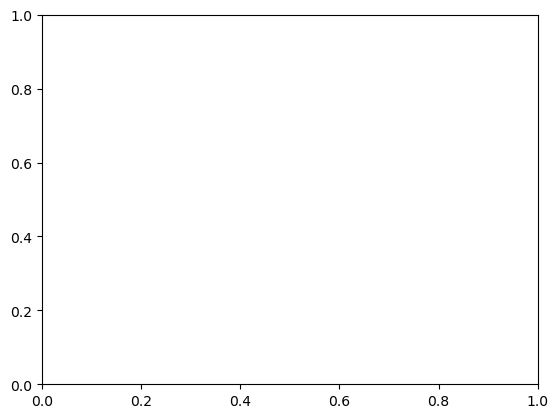

In [102]:
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Checking the MSE of Model

As this is for evaluation, it is not necessary to optimise with gradients as this will waste time and thus we use torch.no_grad()

Here, we need to unscale the data to calculate the actual MSE of the results and thus we use the inverse_transform function of the scaler.

'loss' contains the sum of MSE values of all the outputs within the batch

Sum the loss over all the batches and devide by the number of samples.

The overall MSE is reported.

In [103]:
def check_mse(loader,model): 
    if loader == train_loader: 
        print("checking mse on training data")
    else:
        print("checking mse on test data")
    overall_loss = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad(): 
        for x,y in loader:
            x= x.to(device=device)
            y= y.to(device=device)
            
            outputs = model(x)
            unscaled_outputs = scaler.inverse_transform(np.array(outputs))
            unscaled_y = scaler.inverse_transform(np.array(y))
            
            unscaled_outputs = torch.from_numpy(unscaled_outputs)
            unscaled_y = torch.from_numpy(unscaled_y)            
            
            loss = F.mse_loss(unscaled_outputs,unscaled_y,reduction='sum')
            
            overall_loss += loss.item()
            num_samples += x.size(0)

        mse = overall_loss / num_samples
        print(f"MSE: {mse:.4f}")
        
    model.train()

In [104]:
check_mse(train_loader,model)
check_mse(val_loader,model)

checking mse on training data


ValueError: Expected 2D array, got 1D array instead:
array=[0.30567685 0.31441048 0.36681223 0.34934497 0.32478166 0.32605532
 0.2934498  0.24454148 0.28820962 0.28275108 0.3018559  0.2852984
 0.31441048 0.34643376 0.40247452 0.2576419 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

The mean squared error is around 1/4 of the mean value for mean temperature for the bi-directional LSTM model, which is rather large.

However, put into context, the values show that the temperature predictions vary about 2-3 degrees on average, which is rather acceptable.

## Error Analysis

Examine the input data, output and MSE of the validation set to analyse which situations give rise to larger deviations and how we can handle this.

In [109]:
predictions = np.array(predictions)
true_y = np.array(true_y)

mse = F.mse_loss(true_y, predictions)

error_df = pd.DataFrame({
    'Input Values': val_loader.dataset.inputs,
    'True Y': true_y,
    'Predicted Y': predictions,
    'MSE': mse
})

error_df.to_csv('error_analysis.csv', index=False)

TypeError: 'int' object is not callable

## Kevin's Comments

1. It's a good practice to plot the train test loss. Extract the graph from tensorboard here.  There are other functions in tensorboard.  Learn how to use those.<br>
2. Explain why do you think the MSE is low?   Relative to what?<br>

tensorboard --logdir=runs

